In [2]:
from utils.audio_dataset_utils import train_val_dataset
from network_models.soundsream_models_and_utils.ss_model_dim_red import SSDimRedModel
from network_models.soundsream_models_and_utils.ss_model_conv import SSConvModel3Sec
from network_models.soundsream_models_and_utils.ss_encoded_dataset import ss_encoded_dataset_full
import torch
from torch.utils.data import DataLoader

batch_size = 6

data_set = ss_encoded_dataset_full(
    csvPath="/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/data/allEncodings_version0_12_1.pkl",
    device="cuda")

modelDimRed = SSDimRedModel(eval_mode=True).cuda()
modelConv = SSConvModel3Sec(xSize=512, ySize=175, eval_mode=True).cuda()

trainDS, testDs = train_val_dataset(data_set, val_split=0.1, seed=100)
    modelConv.load_state_dict(torch.load("../content/soundstream/experiments/experiment_v_12_1_NR3_relu/Run_Nr_0/conv/emo_reco_best_ep852_acc_75.pth"))
modelDimRed.load_state_dict(torch.load("../content/soundstream/experiments/experiment_v_12_1_NR3_relu/Run_Nr_0/dimred/emo_reco_best_ep824_acc_70.pth"))

2023-02-20 13:33:16.773476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 13:33:17.624976: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-20 13:33:17.625045: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-20 13:33:17.625050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

<All keys matched successfully>

In [88]:
import pandas as pd
import numpy as np
from numpy import ndarray
json_path ="/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/data/"

def generateParameters(device, model, dataset, labels):
    loader = DataLoader(dataset, shuffle=False, batch_size=1)
    d ={}

    for label in labels:
        d.update({label: []})

    with torch.no_grad():
        for batch, (X, z) in enumerate(loader):
            X, z = X.to(device),  z.to(device)
            dims, pred = model(X, return_with_dims= True)
            label = data_set.encoded_dataset.label_list[z[0].nonzero().cpu().numpy()[0][0]]
            dims = dims.cpu().numpy()[0]
            d[label].append(dims)
            if batch % 500 == 0:
                print(f"{batch*batch_size} of {len(dataset)}")
    return d

def genAvgAndVarByLabel(data: list[ndarray[float]], labelList):
    d = pd.DataFrame()
    for label in labelList:
        mean = np.round(np.asarray(data[label]).mean(keepdims=True, axis=0), 2)
        var = np.round(np.asarray(data[label]).var(keepdims=True, axis=0), 2)
        d[label] = pd.Series([mean[0], var[0]], index=["mean", "var"])
        #d.update({label : pd.Series([mean, var], index=["mean", "var"])})
        #d.update({label : pd.Series([mean, var], index=["mean", "var"])})

    return d

def genAvgFullByLabel(fulldata: list[dict], label_list, modelNameList):
    fullDict = {}
    for model in range(len(modelNameList)):
        fullDict.update({modelNameList[model]: genAvgAndVarByLabel(fulldata[model], label_list)})
    return fullDict

def genAvgAndVar(data: list[list[ndarray[float]]], modelNameList):
    d = {}
    for i in range(len(modelNameList)):
        mean = np.mean(np.asarray(data[i]), axis=0)
        var = np.var(np.asarray(data[i]), axis=0)
        d.update({modelNameList[i] : pd.Series([mean, var], index=["mean", "var"])})
    return d

def genAvgFull(fulldata: list[dict], label_list, modelNameList):
    fullDict = {}
    for label in label_list:
        fullDict.update({label: genAvgAndVar([fd[label] for fd in fulldata], modelNameList)})
    return fullDict

def write_latex(fileName, string):
    print(f"writing: {string} \n to {json_path+fileName}.txt")
    file = open(json_path+f"{fileName}.txt", "w")
    file.write(string)
    file.close()

In [89]:
arra = generateParameters("cuda", modelConv, testDs, data_set.encoded_dataset.label_list)
arra_dr = generateParameters("cuda", modelDimRed, testDs, data_set.encoded_dataset.label_list)


0 of 610
3000 of 610
0 of 610
3000 of 610


In [ ]:
np.asarray(arra["angry"]).mean(keepdims=True, axis=0)

In [91]:
#asaa = pd.DataFrame(genAvgFull([arra, arra_dr], data_set.encoded_dataset.label_list ,["conv", "dimred"]))
asaa = genAvgFullByLabel([arra, arra_dr], data_set.encoded_dataset.label_list ,["conv", "dimred"])

write_latex("conv_mean_var" ,asaa["conv"].T.to_latex(float_format="{{:0.2f}}"))
write_latex("dimred_mean_var" ,asaa["dimred"].T.to_latex(float_format="{{:0.2f}}"))
#asaa["conv"].to_latex()

writing: \begin{tabular}{lll}
\toprule
{} &                          mean &                       var \\
\midrule
angry    &     [-0.7, 0.81, -0.57, -0.9] &    [0.3, 0.2, 0.13, 0.12] \\
disgust  &   [-0.88, -0.67, 0.16, -0.93] &  [0.13, 0.38, 0.36, 0.05] \\
fear     &     [0.72, 0.59, -0.79, 0.62] &  [0.24, 0.18, 0.23, 0.44] \\
happy    &    [0.65, 0.78, -0.35, -0.42] &    [0.4, 0.22, 0.61, 0.6] \\
neutral  &  [-0.84, -0.76, -0.89, -0.85] &   [0.21, 0.3, 0.07, 0.17] \\
sad      &   [-0.64, -0.69, -0.86, 0.63] &  [0.41, 0.36, 0.11, 0.45] \\
surprise &     [0.76, 0.78, 0.59, -0.79] &   [0.29, 0.23, 0.4, 0.25] \\
\bottomrule
\end{tabular}
 
 to /home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/data/conv_mean_var.txt
writing: \begin{tabular}{lll}
\toprule
{} &                         mean &                       var \\
\midrule
angry    &    [0.59, 0.55, 0.45, -0.49] &  [0.27, 0.31, 0.38, 0.33] \\
disgust  &  [-0.71, -0.52, -0.36, 0.58] &  [0.17, 0.27, 0

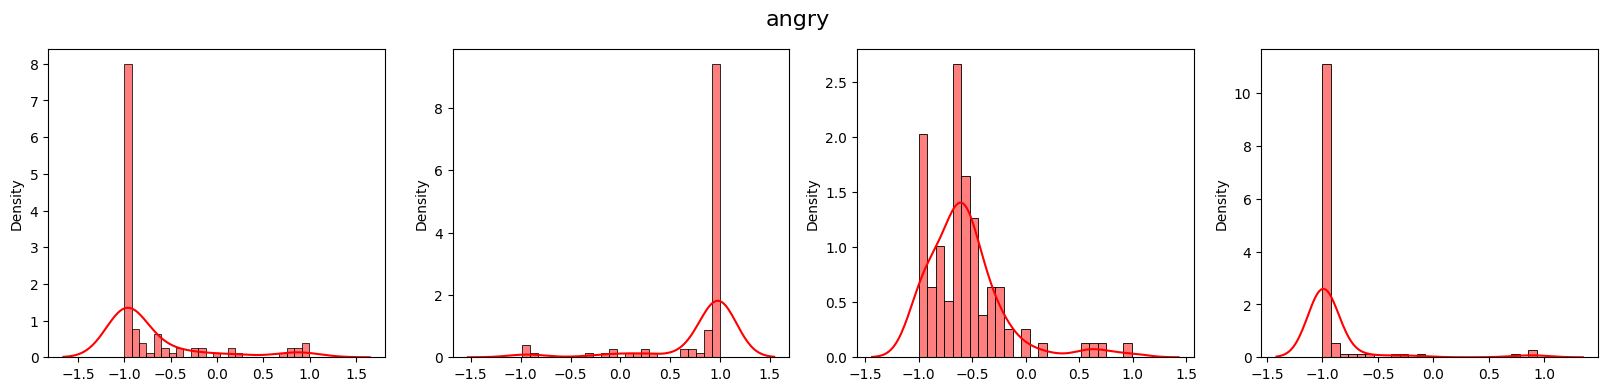

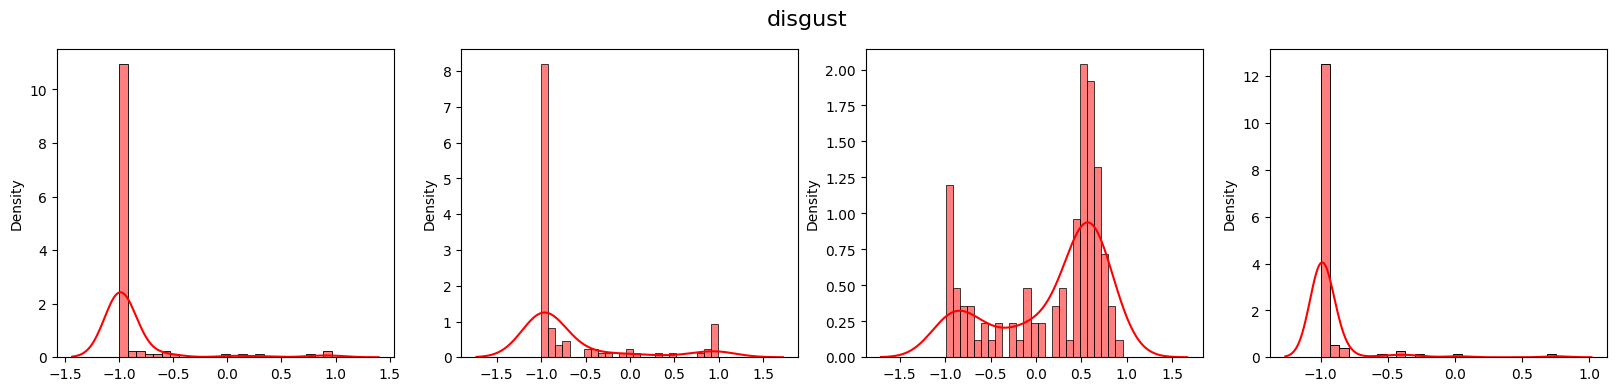

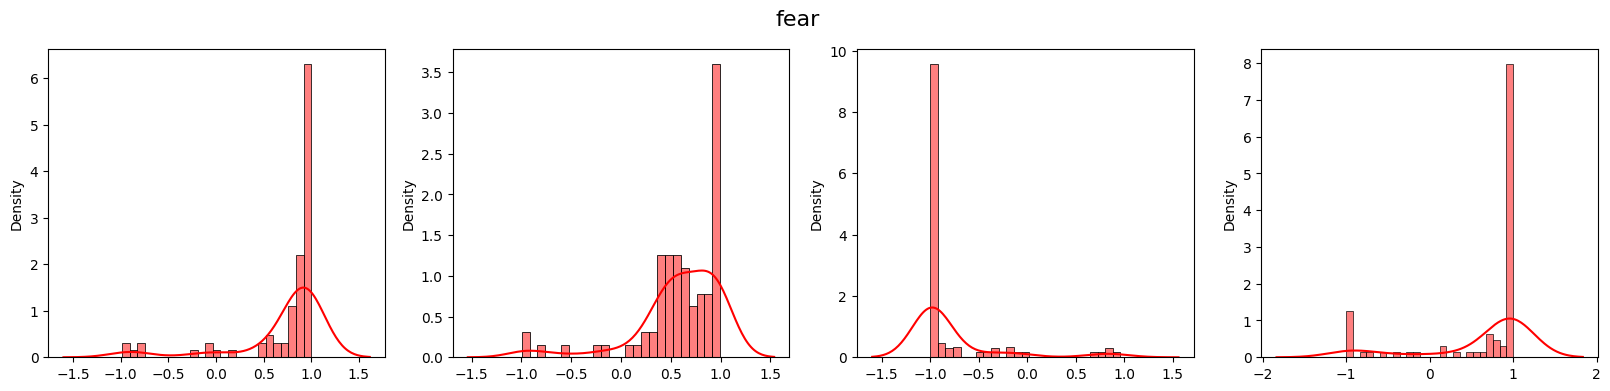

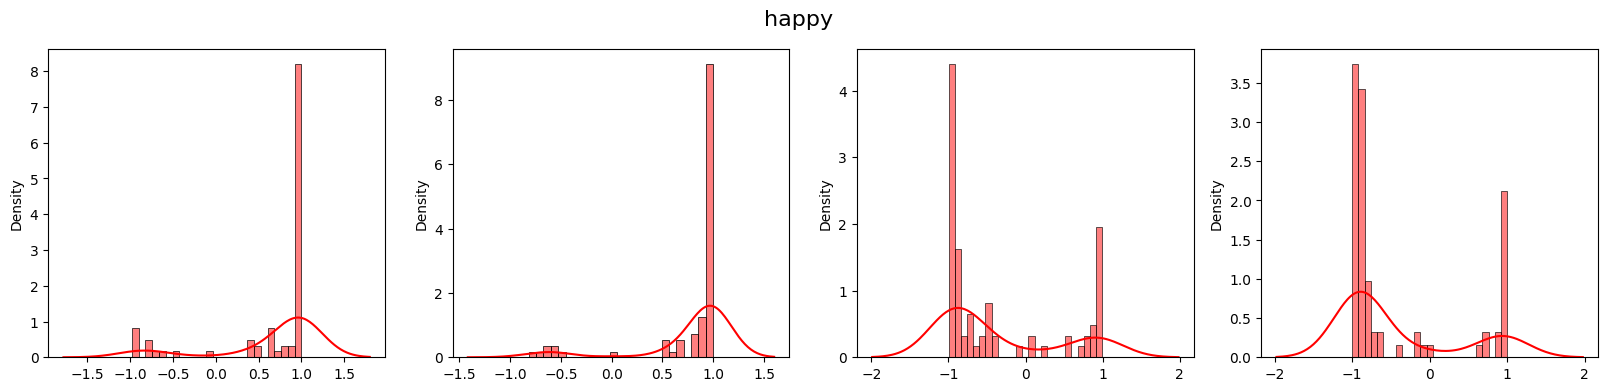

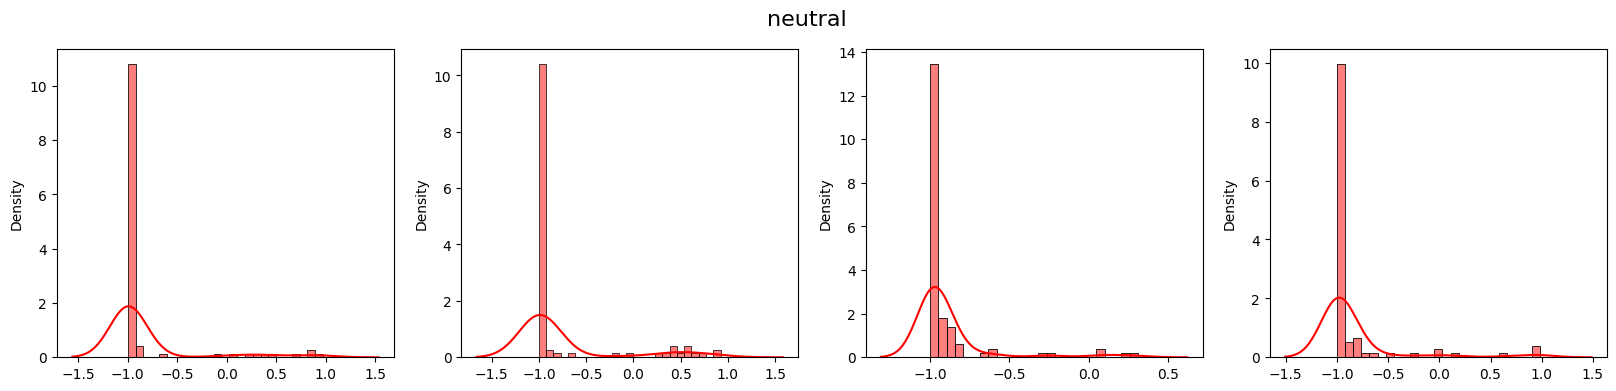

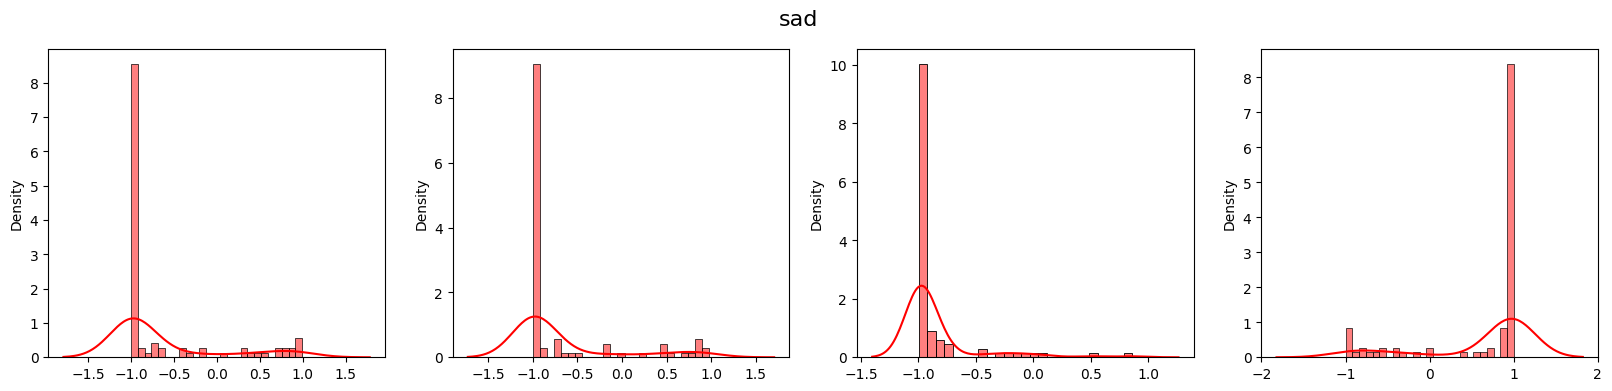

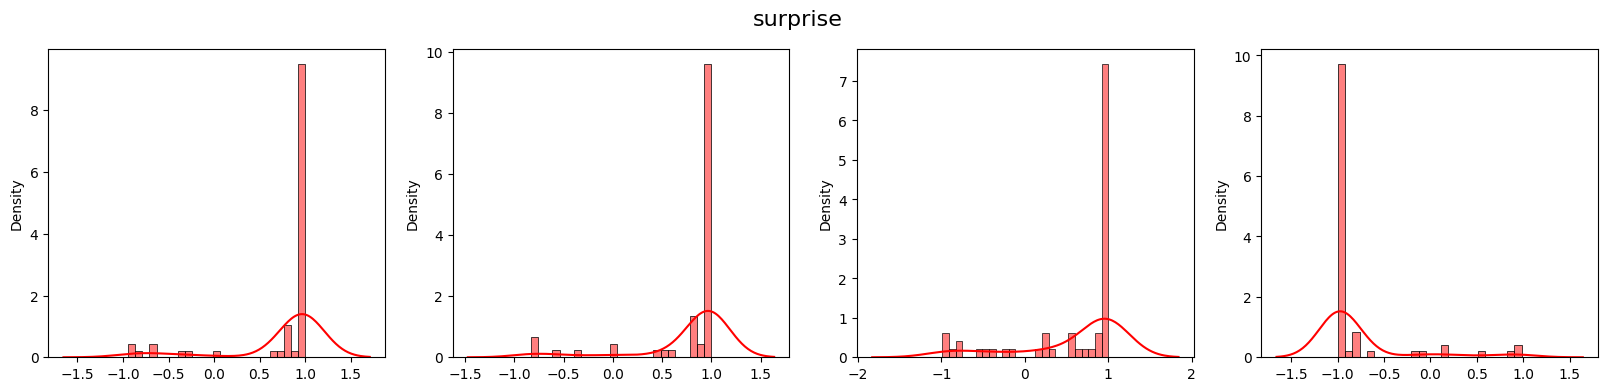

In [10]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns





for label in data_set.encoded_dataset.label_list:
    #print(f"--------------------------------------------- {label} --------------------------------------------")
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
    fig.suptitle(f'{label}', fontsize=16)
    #sns.displot(arra[label], bins=100, color="g", kde=True)
    sns.histplot([item[0] for item in arra[label]], bins=25, color="r", ax=ax[0], kde=True, kde_kws={"cut": 3}, stat="density")
    sns.histplot([item[1] for item in arra[label]], bins=25, color="r", ax=ax[1], kde=True, kde_kws={"cut": 3}, stat="density")
    sns.histplot([item[2] for item in arra[label]], bins=25, color="r", ax=ax[2], kde=True, kde_kws={"cut": 3}, stat="density")
    sns.histplot([item[3] for item in arra[label]], bins=25, color="r", ax=ax[3], kde=True, kde_kws={"cut": 3}, stat="density")
    plt.show()

# sns.displot(arra["angry"], bins=100, color="g", kde=True)
# plt.show()


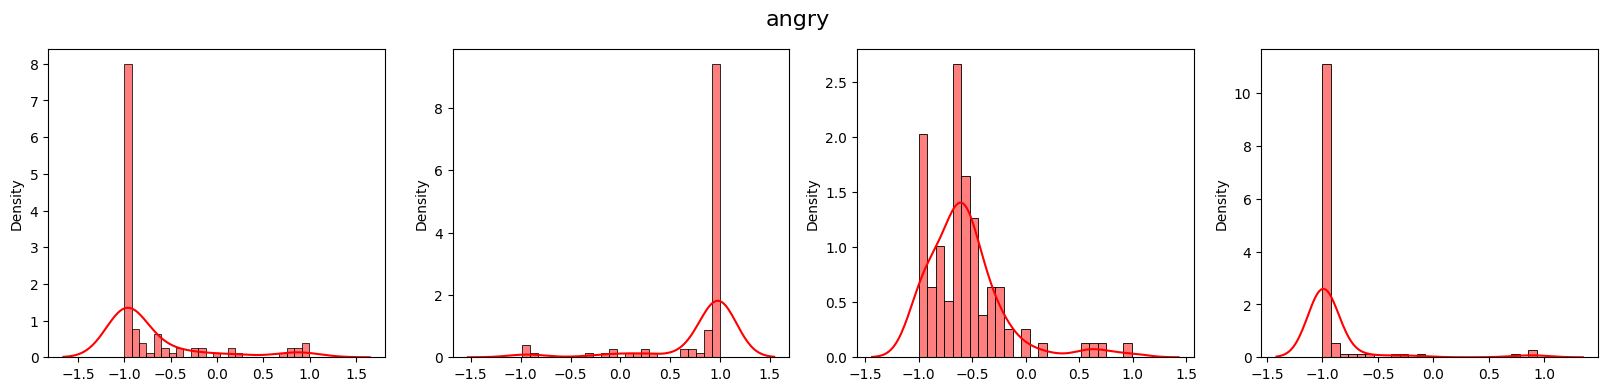

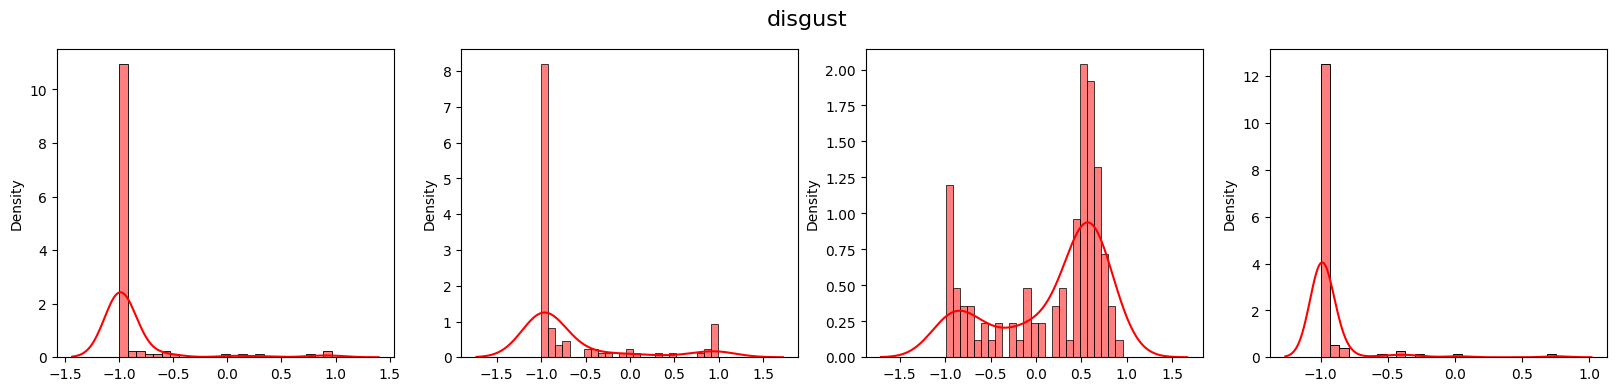

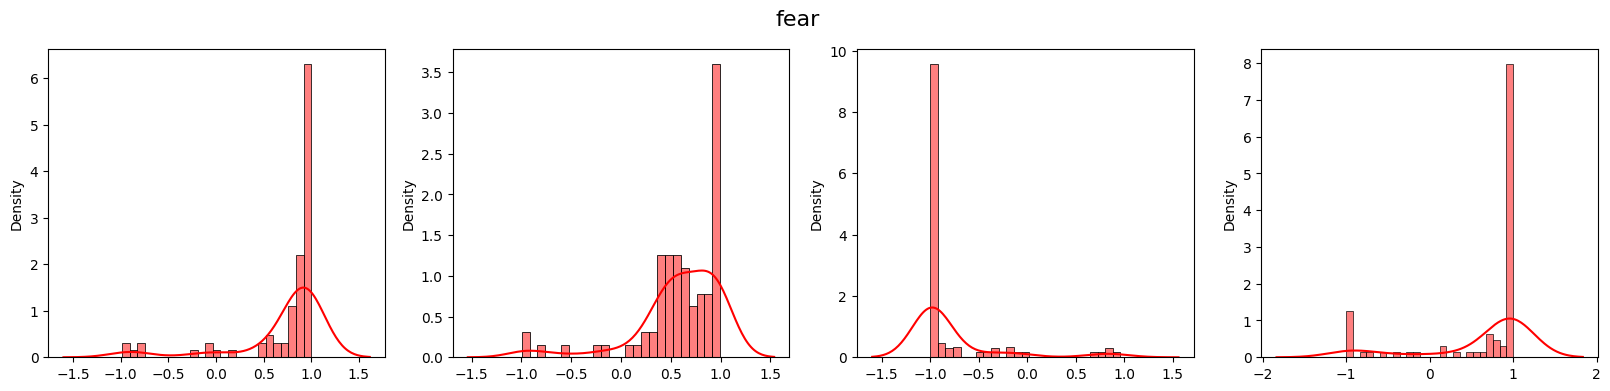

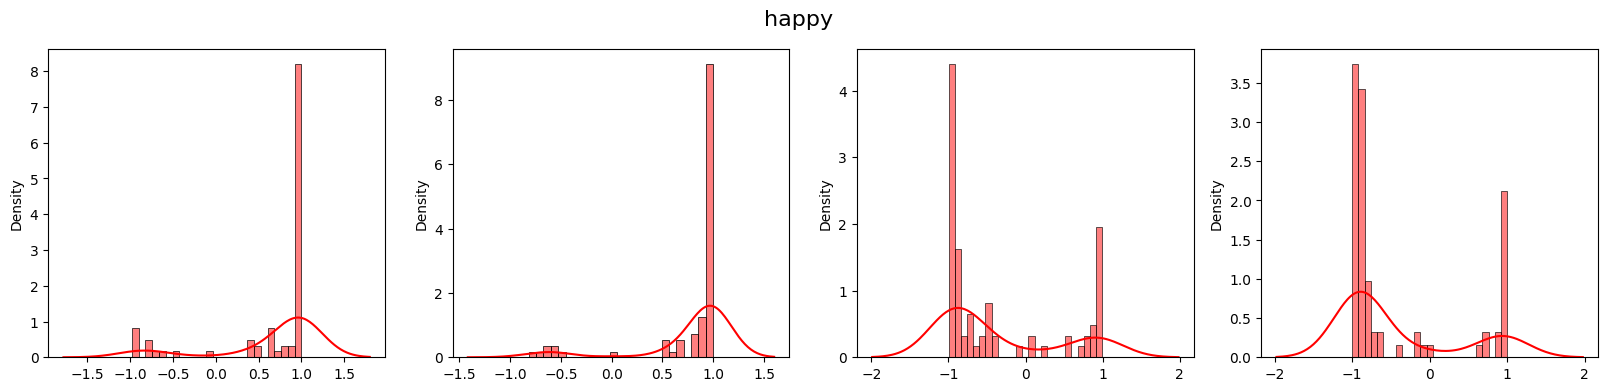

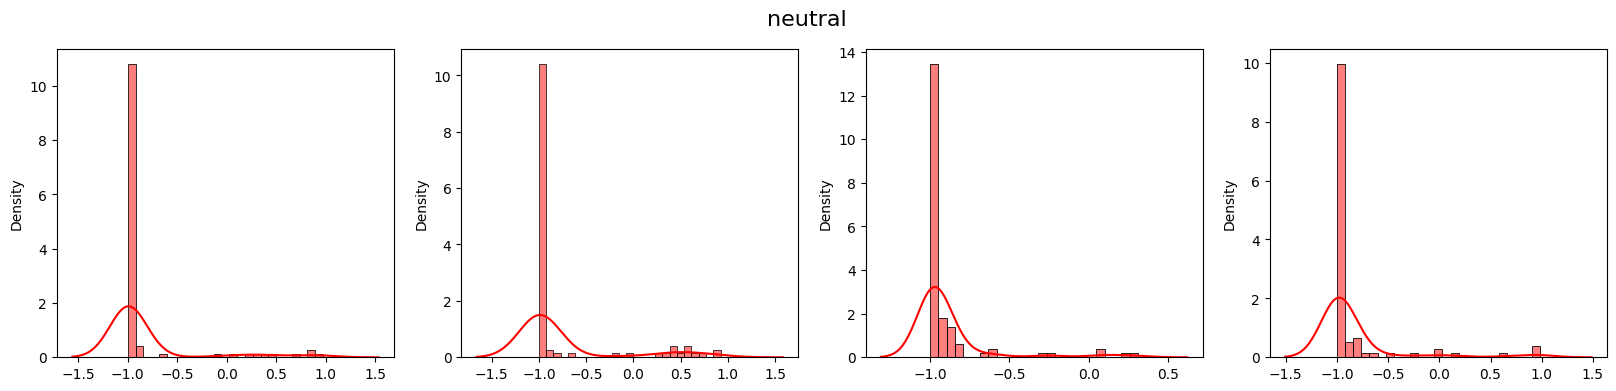

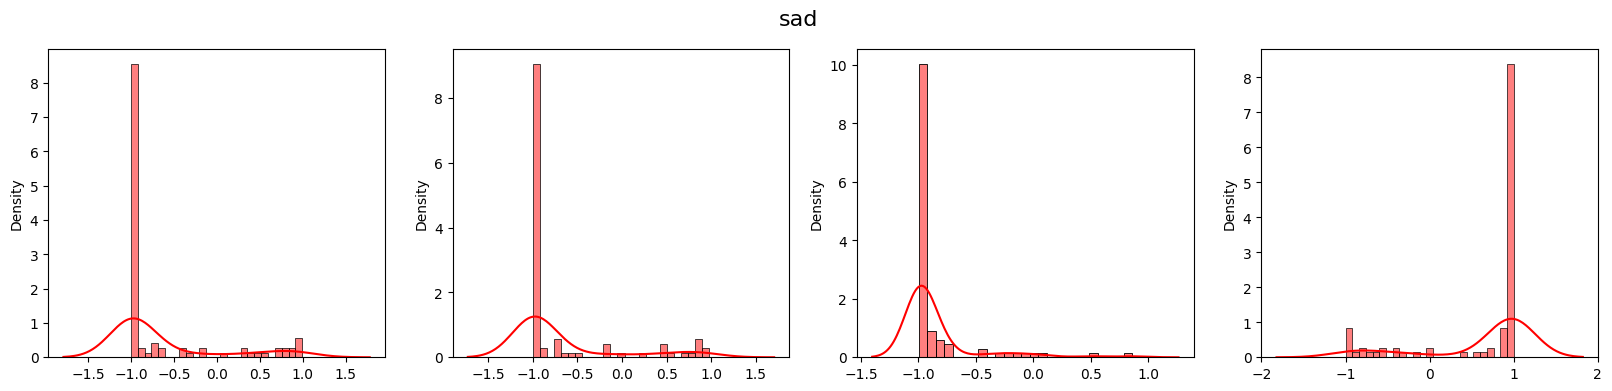

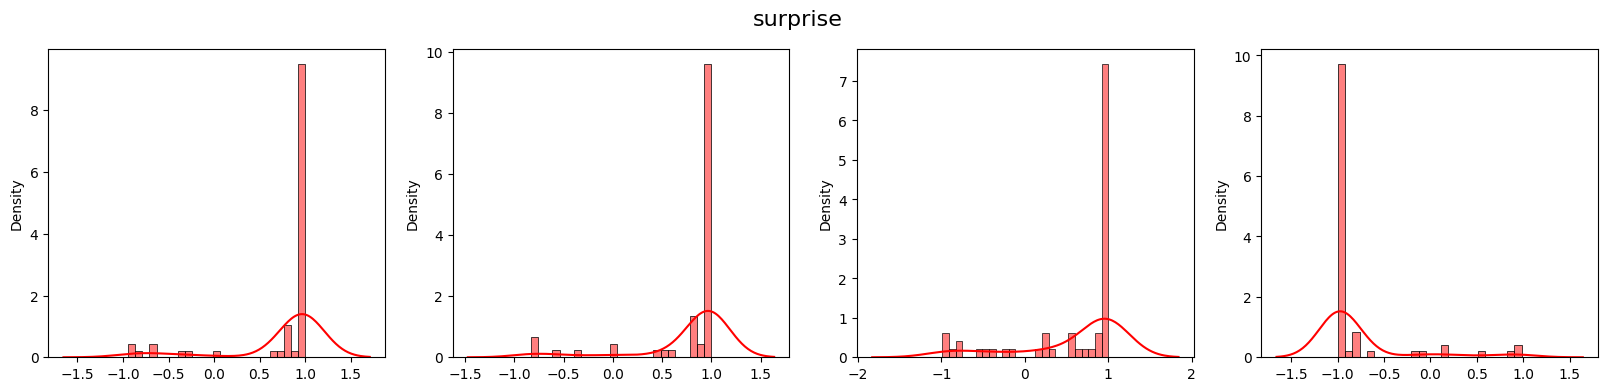

In [9]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns





for label in data_set.encoded_dataset.label_list:
    #print(f"--------------------------------------------- {label} --------------------------------------------")
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
    fig.suptitle(f'{label}', fontsize=16)
    #sns.displot(arra[label], bins=100, color="g", kde=True)
    sns.histplot([item[0] for item in arra[label]], bins=25, color="r", ax=ax[0], kde=True, kde_kws={"cut": 3}, stat="density")
    sns.histplot([item[1] for item in arra[label]], bins=25, color="r", ax=ax[1], kde=True, kde_kws={"cut": 3}, stat="density")
    sns.histplot([item[2] for item in arra[label]], bins=25, color="r", ax=ax[2], kde=True, kde_kws={"cut": 3}, stat="density")
    sns.histplot([item[3] for item in arra[label]], bins=25, color="r", ax=ax[3], kde=True, kde_kws={"cut": 3}, stat="density")
    plt.show()